In [70]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import copy
import yaml

In [71]:
from workers.utils.misc import save_yaml, timestamp

In [72]:
def load_yaml(path):
    with open(path, mode='r') as file:
        return yaml.load(file, Loader=yaml.FullLoader)

In [3]:
log_dir = 'workers/logs/'
log_files = os.listdir(log_dir)

In [4]:
def worker_coords():
    
    # FETCH FILES
    log_dir = 'workers/logs/'
    log_files = os.listdir(log_dir)
    
    col_refs = {
        'iot': '#e75f5b',
        'edge': '#f2ae42',
        'storage': '#52af52'
    }
    
    x=[]
    y=[]
    colors=[]
    
    # ['#f2ae42', '#a93581', '#ffc0cb', '#928478']
    
    # LOOP THROUGH
    for log_file in log_files:
        result = load_yaml(log_dir + log_file)

        try:
            coords = result.details.location
            
            x.append(coords.x)
            y.append(coords.y)
            colors.append(col_refs[result.details.worker])
        except:
            pass
            
    return x, y, colors

In [40]:
def find_closest(target, nodes):
    best_node = None
    best_distance = float('inf')

    # NO EDGES EXIST
    if len(nodes) == 0:
        return best_node

    # FIND THE CLOSEST
    for node in nodes:

        # COMPUTE STRAIGHT LINE DISTANCE
        P1 = abs(target['location']['x'] - node['location']['x'])**2
        P2 = abs(target['location']['y'] - node['location']['y'])**2
        distance = math.sqrt(P1 + P2)

        # UPDATE WHEN A BETTER DISTANCE IS FOUND
        if distance < best_distance:
            best_node = node
            best_distance = distance

    return best_node['location']

In [171]:
def generate_dataset(iot_count, edge_count, verifier_count, storage_count, grid_size):
    nodes = []
    
    # RANDOM COORD GENERATION
    smallest = 0+0.5
    largest = grid_size-0.5
    generate_node = lambda: np.random.uniform(smallest, largest)
    
    # CREATE SERVICE NODE
    nodes.append({
        'type': 'service',
        'location': {
            'x': generate_node(),
            'y': generate_node(),
        },
        'connectors': []
    })
    
    # CREATE STORAGE NODES
    for _ in range(storage_count):
        nodes.append({
            'type': 'storage',
            'location': {
                'x': generate_node(),
                'y': generate_node(),
            },
            'connectors': []
        })
    
    # SEPARATE STORAGE DEVICES
    storages = nodes[1:]
    
    # CREATE EDGES
    for _ in range(edge_count):
        nodes.append({
            'type': 'edge',
            'location': {
                'x': generate_node(),
                'y': generate_node(),
            },
            'connectors': []
        })
        
        # FIND NEAREST STORAGE
        nodes[-1]['connectors'].append(find_closest(nodes[-1], storages))
        
    # SEPARATE EDGE DEVICES
    edges = nodes[(1+len(storages)):]
    
    # CREATE IOT NODES
    for _ in range(iot_count):
        nodes.append({
            'type': 'iot',
            'location': {
                'x': generate_node(),
                'y': generate_node(),
            },
            'connectors': []
        })
        
        # FIND NEAREST EDGE
        nodes[-1]['connectors'].append(find_closest(nodes[-1], edges))
        
    # CREATE VERIFIERS
    for _ in range(verifier_count):
        nodes.append({
            'type': 'verifier',
            'location': {
                'x': generate_node(),
                'y': generate_node(),
            },
            'connectors': [nodes[0]['location']]
        })
    
    # TIMESTAMP
    now = int(timestamp())
    filename = 'workers/networks/{}.yml'.format(now)
    
    # SAVE IT
    save_yaml(filename, {
        'config': {
            'iot_count': iot_count,
            'edge_count': edge_count,
            'verifier_count': verifier_count,
            'storage_count': storage_count,
            'grid_size': grid_size
        },
        'nodes': nodes
    })
    
    return nodes

In [140]:
def extract_coords(nodes):
    xs, ys, colors, sizes = [], [], [], []
    
    col_refs = {
        'iot': '#e75f5b',
        'edge': '#3378ca',
        'service': '#928478',
        'verifier': '#52af52',
        'storage': '#b896c6'
    }
    
    node_sizes = {
        'iot': 50,
        'edge': 200,
        'storage': 100,
        'service': 400,
        'verifier': 100,
    }
    
    label_offset = {
        'iot': 0.13,
        'edge': 0.2,
        'service': 0.27,
        'verifier': 0.17,
        'storage': 0.17
    }

    for node in nodes:
        xs.append(node['location']['x'])
        ys.append(node['location']['y'])
        colors.append(col_refs[node['type']])
        sizes.append(node_sizes[node['type']])

    return xs, ys, colors, sizes, label_offset, col_refs

In [141]:
def create_map(iot_count, edge_count, verifier_count, storage_count, grid_size):
    
    # CREATE DATASET FROM LOG FILES
    nodes = generate_dataset(iot_count, edge_count, verifier_count, storage_count, grid_size)
    xs, ys, colors, sizes, offsets, col_refs = extract_coords(nodes)
    
    # SETTINGS
    line_opacity = 0.5
    line_width = 1
    
    # CREATE FIGURE
    fig, ax = plt.subplots(figsize=(grid_size, grid_size), dpi=100)
    
    # DRAW DOTS
    ax.scatter(xs, ys, s=sizes, c=colors, alpha=0.95, zorder=10, vmin=0, vmax=100)
    
    # DRAW LINES
    for node in nodes:
        if 'connectors' in node:
            
            # CONNECTOR LINES
            for index, _ in enumerate(node['connectors']):
                ax.plot(
                    [node['location']['x'], node['connectors'][index]['x']], 
                    [node['location']['y'], node['connectors'][index]['y']],
                    '-',
                     color=col_refs[node['type']],
                     linewidth=line_width,
                     alpha=line_opacity
                )
        
        # ADD ANNOTATION
        ax.annotate(
            node['type'].upper(),
            (node['location']['x'], node['location']['y'] + offsets[node['type']]),
            ha='center'
        )

    # SET LIMITS
    ax.set(
        xlim=(0, grid_size), xticks=np.arange(0, grid_size),
        ylim=(0, grid_size), yticks=np.arange(0, grid_size)
    )

    # SET GRID & RENDER PLOT
    plt.grid(linewidth=0.5, alpha=0.2)
    plt.show()

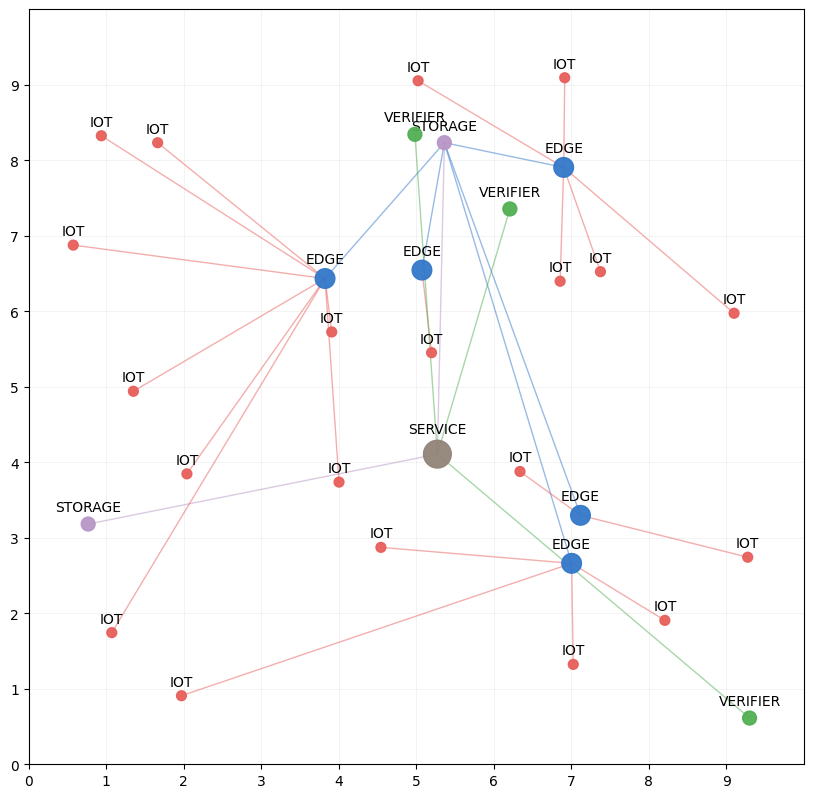

In [164]:
dataset = create_map(20, 5, 3, 2, 10)

In [197]:
def load_network(filename):

    path = 'workers/networks/{}.yml'.format(filename)
    dataset = load_yaml(path)
    
    # CREATE DATASET FROM LOG FILES
    nodes = dataset['nodes']
    grid_size = dataset['config']['grid_size']
    xs, ys, colors, sizes, offsets, col_refs = extract_coords(nodes)
    
    # SETTINGS
    line_opacity = 0.5
    line_width = 1
    
    # CREATE FIGURE
    fig, ax = plt.subplots(figsize=(grid_size, grid_size), dpi=100)
    
    # DRAW DOTS
    ax.scatter(xs, ys, s=sizes, c=colors, alpha=0.95, zorder=10, vmin=0, vmax=100)
    
    # DRAW LINES
    for node in nodes:
        if 'connectors' in node:
            
            # CONNECTOR LINES
            for index, _ in enumerate(node['connectors']):
                ax.plot(
                    [node['location']['x'], node['connectors'][index]['x']], 
                    [node['location']['y'], node['connectors'][index]['y']],
                    '-',
                     color=col_refs[node['type']],
                     linewidth=line_width,
                     alpha=line_opacity
                )
                
        ax.plot(
            [node['location']['x'], nodes[0]['location']['x']], 
            [node['location']['y'], nodes[0]['location']['y']],
            '-',
             color='gray',
             linewidth=line_width,
             alpha=0.1
        )
        
        # ADD ANNOTATION
        ax.annotate(
            node['type'].upper(),
            (node['location']['x'], node['location']['y'] + offsets[node['type']]),
            ha='center'
        )

    # SET LIMITS
    ax.set(
        xlim=(0, grid_size), xticks=np.arange(0, grid_size),
        ylim=(0, grid_size), yticks=np.arange(0, grid_size)
    )

    # SET GRID & RENDER PLOT
    plt.grid(linewidth=0.5, alpha=0.2)
    plt.show()

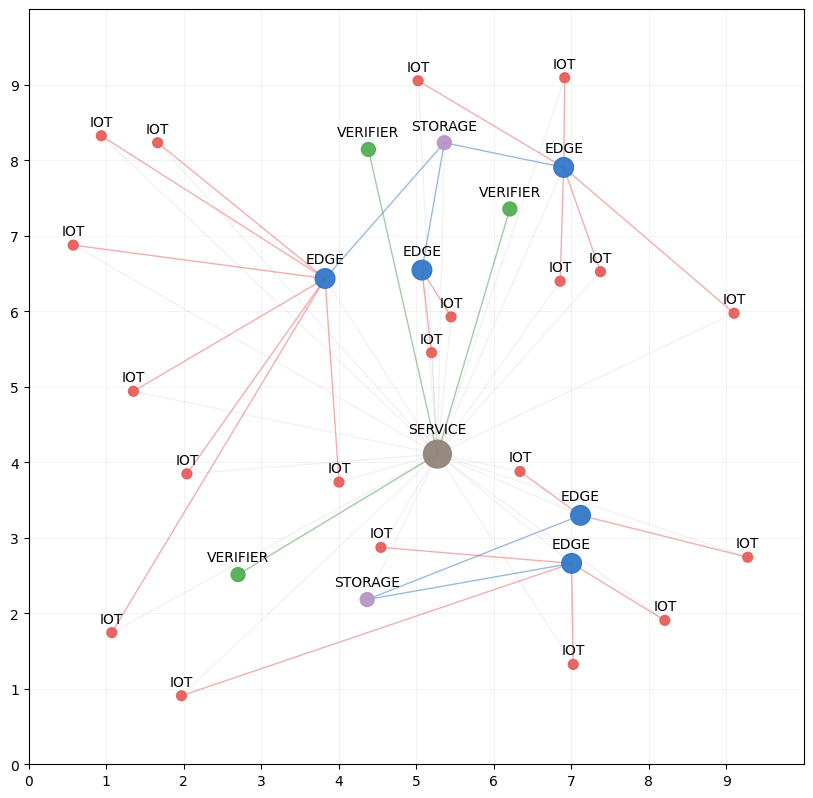

In [205]:
load_network('1656955700')

In [ ]:
from web3 import Web3

In [ ]:
# w3 = Web3(Web3.WebsocketProvider('wss://127.0.0.1:8545'))
w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:8545'))

In [ ]:
w3.isConnected()

In [ ]:
foo = load_yaml('workers/graph_test.yml')

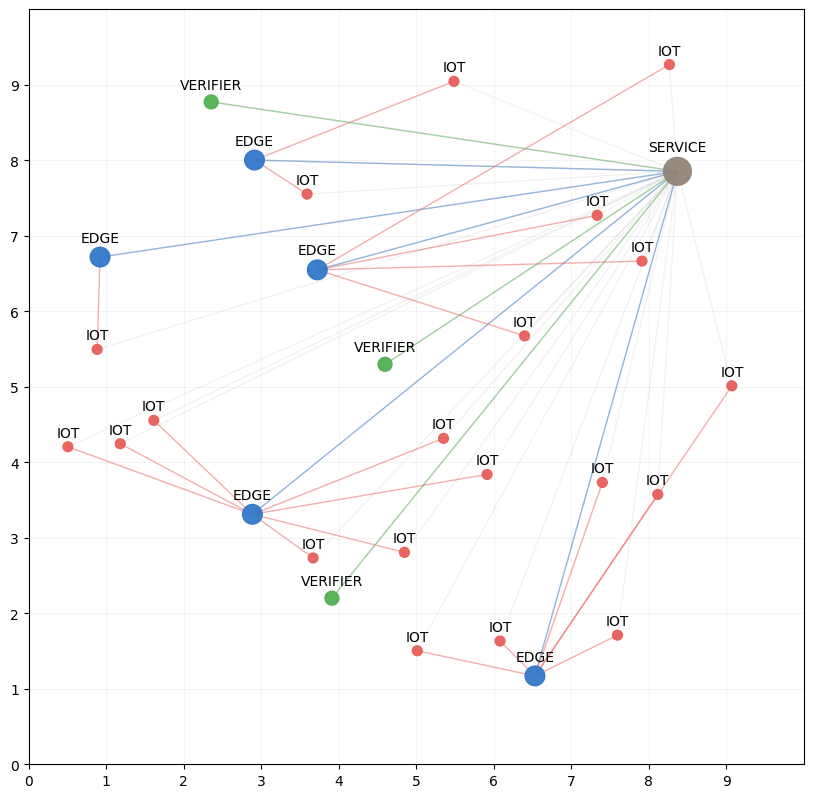

In [112]:
load_network('aesthetic')

In [113]:
def load_network(filename):

    path = 'workers/networks/{}.yml'.format(filename)
    dataset = load_yaml(path)
    
    # CREATE DATASET FROM LOG FILES
    nodes = dataset['nodes']
    grid_size = dataset['config']['grid_size']
    xs, ys, colors, sizes, offsets, col_refs = extract_coords(nodes)
    
    # SETTINGS
    line_opacity = 0.5
    line_width = 1
    
    # CREATE FIGURE
    fig, ax = plt.subplots(figsize=(grid_size, grid_size), dpi=100)
    
    # DRAW DOTS
    ax.scatter(xs, ys, s=sizes, c=colors, alpha=0.95, zorder=10, vmin=0, vmax=100)
    
    # DRAW LINES
    for node in nodes:
        if 'connector' in node:
            
            # CONNECTOR LINE
            ax.plot(
                [node['location']['x'], node['connector']['x']], 
                [node['location']['y'], node['connector']['y']],
                '-',
                 color=col_refs[node['type']],
                 linewidth=line_width,
                 alpha=line_opacity
            )
            
            # SERVICE LINE
            ax.plot(
                [node['location']['x'], nodes[0]['location']['x']],
                [node['location']['y'], nodes[0]['location']['y']],
                '-',
                color='gray',
                linewidth=line_width,
                alpha=0.1
            )
        
        # ADD ANNOTATION
        ax.annotate(
            node['type'].upper(),
            (node['location']['x'], node['location']['y'] + offsets[node['type']]),
            ha='center'
        )

    # SET LIMITS
    ax.set(
        xlim=(0, grid_size), xticks=np.arange(0, grid_size),
        ylim=(0, grid_size), yticks=np.arange(0, grid_size)
    )

    # SET GRID & RENDER PLOT
    plt.grid(linewidth=0.5, alpha=0.2)
    plt.show()